In [1]:
import state_preparation.waveplates as wp
import state_preparation.utils as ut
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

# State Preparation

In [2]:
# States are uniformly distributed on the Bloch sphere for fixed theta sweeping phi
thetas = [np.pi / 2, np.pi / 4, np.pi / 8]
phis = np.linspace(0, 2 * np.pi, 20)

# Prepare the states
ket_h = qt.basis(2, 0)
ket_v = qt.basis(2, 1)

states = [
    [
        np.cos(theta / 2) * ket_h + np.exp(1j * phi) * np.sin(theta / 2) * ket_v
        for phi in phis
    ]
    for theta in thetas
]

## Waveplate Angles

In [3]:
# get the waveplate settings required for each state
settings = [
    [wp.get_hwp_qwp_from_target_state(state) for state in theta_states]
    for theta_states in states
]

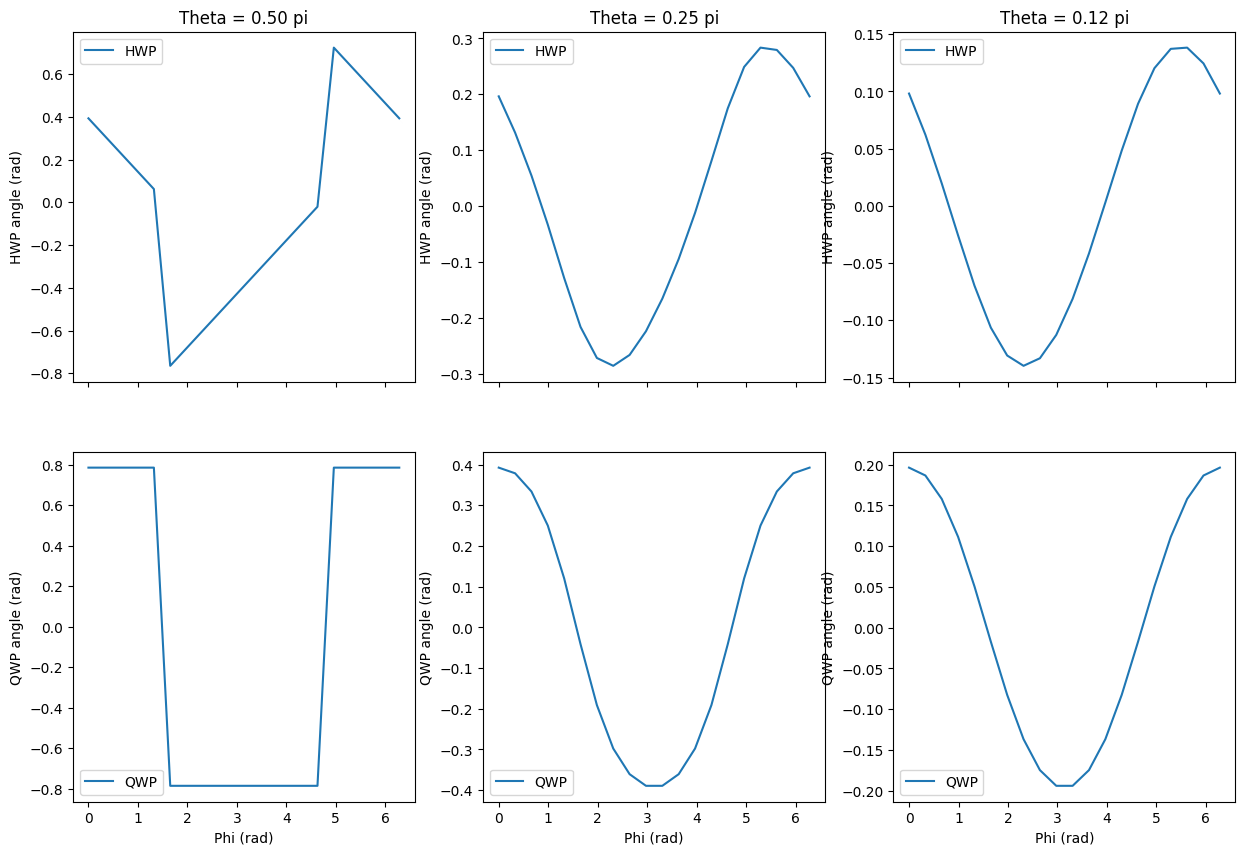

In [4]:
fig, ax = plt.subplots(2, len(thetas), sharex=True)

# set the size
fig.set_size_inches(5 * len(thetas), 10)
for i, theta in enumerate(thetas):
    # plot the waveplate settings
    ax[0, i].plot(phis, [s[0].real for s in settings[i]], label="HWP")
    ax[0, i].set_ylabel("HWP angle (rad)")
    ax[0, i].legend()
    ax[1, i].plot(phis, [s[1] for s in settings[i]], label="QWP")
    ax[1, i].set_ylabel("QWP angle (rad)")
    ax[1, i].legend()
    ax[1, i].set_xlabel("Phi (rad)")
    # label the theta
    ax[0, i].set_title(f"Theta = {theta / np.pi:.2f} pi")
plt.show()

## Final State

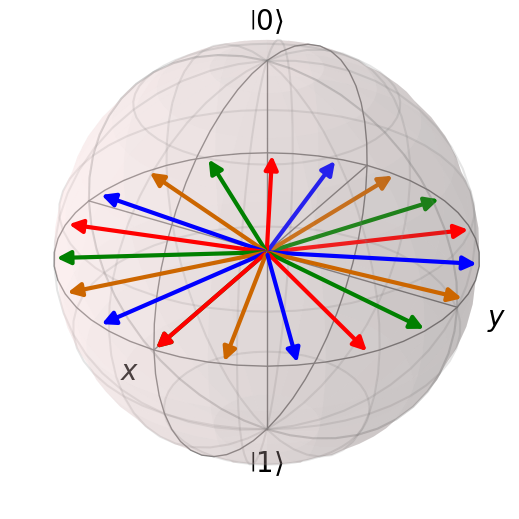

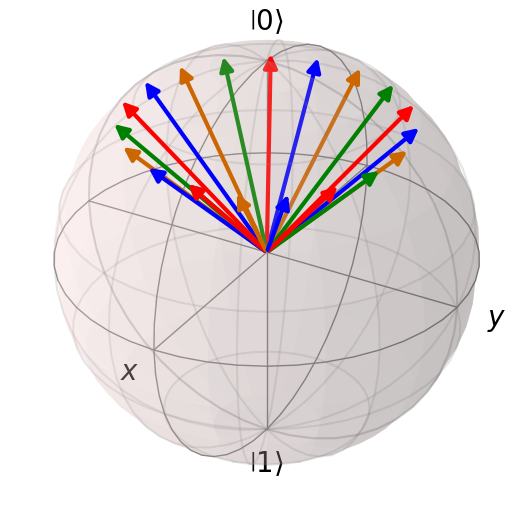

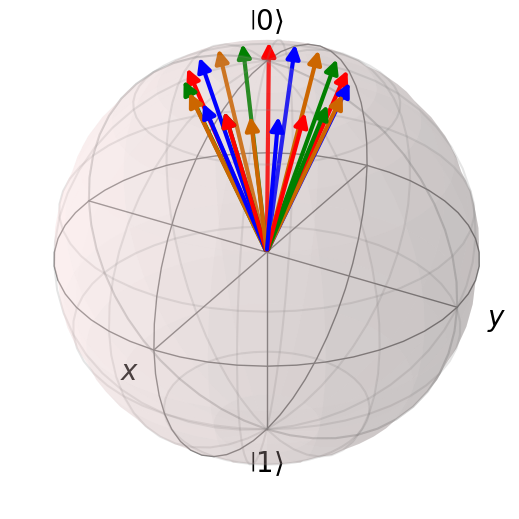

In [5]:
# get the waveplate matrices for each setting
matrices = [
    [[ut.hwp_matrix(s[0]), ut.qwp_matrix(s[1])] for s in settings[i]]
    for i in range(len(thetas))
]

final_states = [[m[1] * m[0] * ket_h for m in matrices[i]] for i in range(len(thetas))]

for i in range(len(thetas)):
    b3d = qt.bloch.Bloch()
    b3d.add_states(final_states[i])
    b3d.title = f"Theta = {thetas[i]/np.pi:.2f} pi"

    b3d.show()

### Error on final state

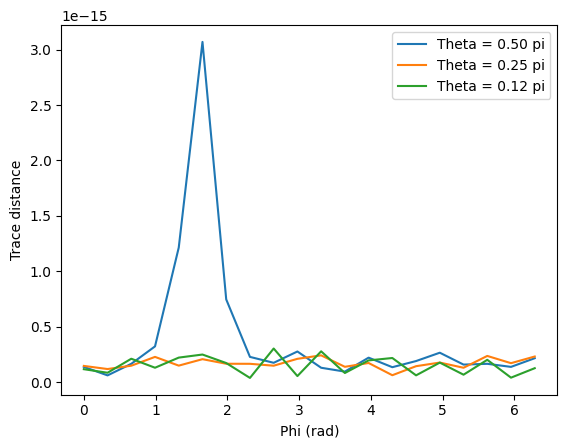

In [6]:
# get the tracedist between the final states and the target states
tracedists = [
    [qt.tracedist(state, states[i][j]) for j, state in enumerate(final_states[i])]
    for i in range(len(thetas))
]

fig, ax = plt.subplots()
for i, theta in enumerate(thetas):
    ax.plot(phis, tracedists[i], label=f"Theta = {theta / np.pi:.2f} pi")
ax.legend()
ax.set_xlabel("Phi (rad)")
ax.set_ylabel("Trace distance")
plt.show()

Conclusion: Waveplate calculation is a negligible source of error on state preparation

## Noise: Waveplate Angles

In [7]:
abs_degree_error = 0.002
noise = np.multiply(abs_degree_error, [[1,1], [1,-1], [-1, 1], [-1, -1]])
noise = np.multiply(np.pi / 180, noise)  # convert to radians

noisy_settings = [
    [[[s[0].real + n[0], s[1] + n[1]] for n in noise] for s in settings[i]]
    for i in range(len(thetas))
]

In [8]:
# get the waveplate matrices for each setting
noisy_matrices = [
    [
        [[ut.hwp_matrix(s[0]), ut.qwp_matrix(s[1])] for s in setting]
        for setting in noisy_settings[i]
    ]
    for i in range(len(thetas))
]

noisy_final_states = [
    [[m[1] * m[0] * ket_h for m in matrices] for matrices in noisy_matrices[i]]
    for i in range(len(thetas))
]

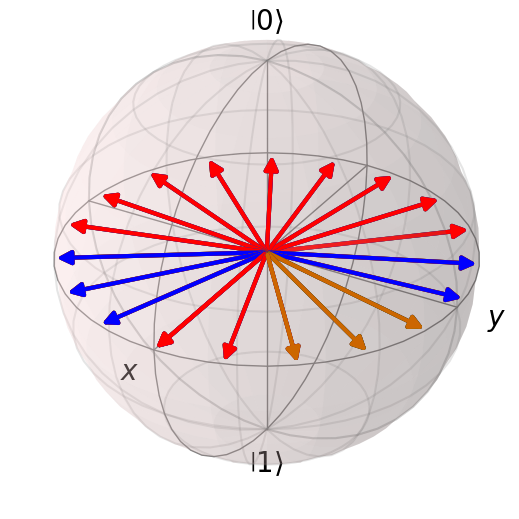

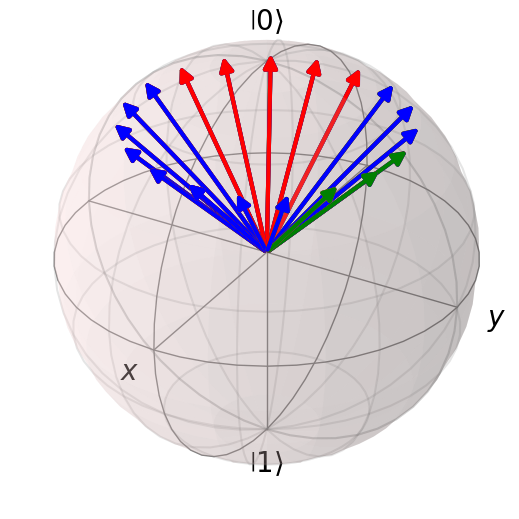

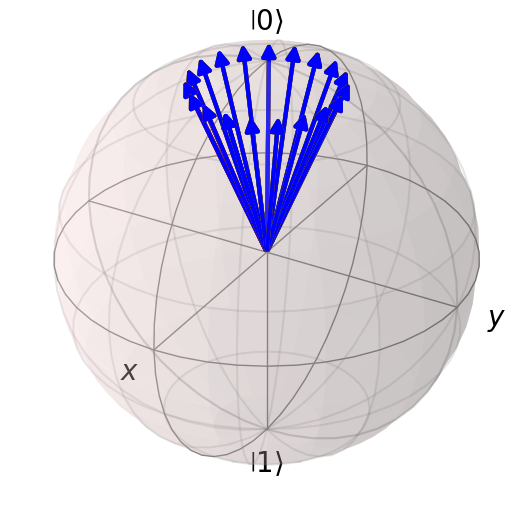

In [9]:
# plot the final states
for i in range(len(thetas)):
    b3d = qt.bloch.Bloch()
    b3d.add_states(np.concatenate(noisy_final_states[i]).ravel())
    b3d.show()

In [10]:
i_theta = 0
i_phi = 0
i_noise = 0
noisy_final_states[i_theta][i_phi][i_noise]

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[-0.5+0.49996509j]
 [-0.5+0.50003491j]]

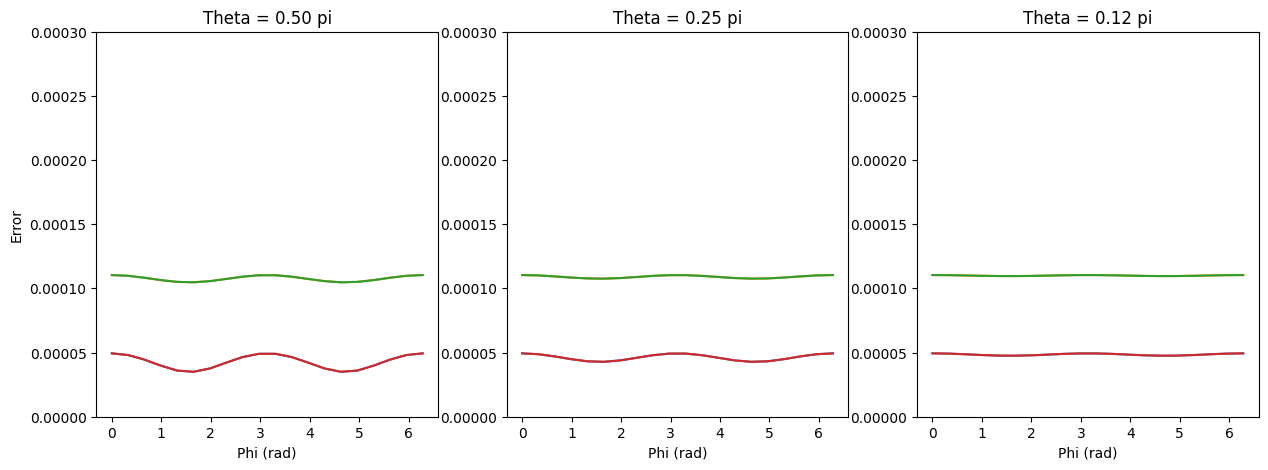

In [16]:
# get the overlap between the noisy final states and the target states
error = [
    [
        [
            qt.tracedist(
                noisy_final_states[i_theta][i_phi][i_noise], states[i_theta][i_phi]
            )
            for i_noise in range(4)
        ]
        for i_phi in range(len(phis))
    ]
    for i_theta in range(len(thetas))
]

fig, ax = plt.subplots(1, len(thetas), figsize=(5 * len(thetas), 5))
for i in range(len(thetas)):
    # set axis min/max
    ax[i].set_ylim([0, 0.0003])
    ax[i].plot(phis, error[i])
    ax[i].set_title(f"Theta = {thetas[i]/np.pi:.2f} pi")
    ax[i].set_xlabel("Phi (rad)")
ax[0].set_ylabel("Error")
plt.show()

Conclusion: Error of 0.002º on waveplate angle will introduce negligible error in state preparation, independent of theta.

### Phi error

In [12]:
def get_theta_phi(psi):
    bloch_vector = [qt.expect(qt.sigmax(), psi), qt.expect(qt.sigmay(), psi), qt.expect(qt.sigmaz(), psi)]
    
    theta = np.arccos(bloch_vector[2])  # θ = arccos(z)
    phi = np.arctan2(bloch_vector[1], bloch_vector[0])  # φ = atan2(y, x)
    
    return theta, phi


In [13]:
noisy_final_states[i_theta][i_phi][i_noise], states[i_theta][i_phi]

(Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[-0.5+0.49996509j]
  [-0.5+0.50003491j]],
 Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[0.70710678]
  [0.70710678]])

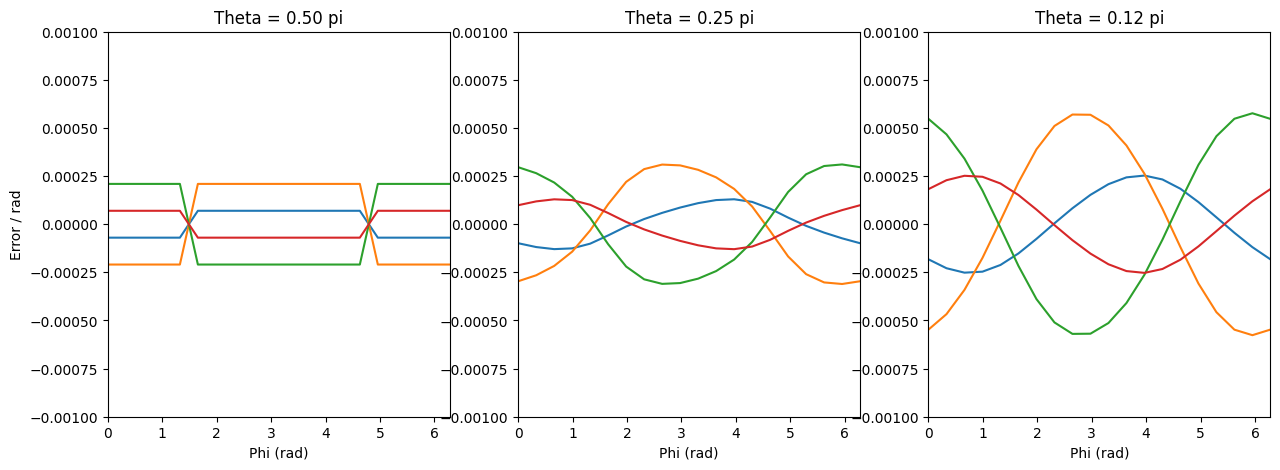

In [18]:
# get the phi error between the noisy final states and the target states
error = [
    [
        [            
            (get_theta_phi(noisy_final_states[i_theta][i_phi][i_noise])[1] - phis[i_phi] + np.pi) % (2 * np.pi) - np.pi
            for i_noise in range(4)
        ]
        for i_phi in range(len(phis))
    ]
    for i_theta in range(len(thetas))
]

fig, ax = plt.subplots(1, len(thetas), figsize=(5 * len(thetas), 5))
for i in range(len(thetas)):
    # set axis min/max
    ax[i].set_ylim([-0.001, 0.001])
    ax[i].set_xlim([0, 2*np.pi])
    ax[i].plot(phis, error[i])
    ax[i].set_title(f"Theta = {thetas[i]/np.pi:.2f} pi")
    ax[i].set_xlabel("Phi (rad)")
ax[0].set_ylabel("Error / rad")
plt.show()

Conslusion: Also negligible error on phi